In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import gensim
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from scipy import interp
import matplotlib.pyplot as plt
from engarde.decorators import has_dtypes
from capstone_project import preprocessor as pre

#from IPython.display import display
%matplotlib inline

In [2]:
# Make sure that the loaded dataframe has the correct layout otherwise throw assertion error 
@has_dtypes(dict(question1=object, question2=object, is_duplicate=int, q1_tokens=object, q2_tokens=object))
def load_data(file_dir, filename):
    """Load dataframe using filename as input. A pandas dataframe is returned and it is checked that it 
    has the correct layout.
    """
    df = pd.read_pickle(file_dir+filename)
    return df

In [3]:
# The current working directory for python is the capstone_project/notebook folder
file_directory = "../output/data/"
prefix = ""

train_data = load_data(file_directory, prefix+"train_data.pkl")
y = train_data["is_duplicate"].values

In [4]:
model_directory = "../output/models/"
skf = pre.load_pickle(model_directory, "kfolds.pkl") 

In [5]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_tokens,q2_tokens
355802,355802,696825,696826,Which are the best songs of Enrique Iglesias?,Which is the best song of Enrique iglesias?,1,"[best, song, enrique, iglesias]","[best, song, enrique, iglesias]"
344874,344874,675864,675865,"What is best way to invest $10,000?","How should I invest $10,000?",1,"[best, way, invest, 10,000]","[invest, 10,000]"
377862,377862,739105,739106,What are some ways to track a mobile number an...,How can one track a mobile number location?,1,"[way, track, mobile, number, location]","[one, track, mobile, number, location]"
62763,62763,124819,124820,Who is the smartest footballer in the world an...,Who is the all time best footballer?,0,"[smart, footballer, world]","[time, best, footballer]"
16614,16614,33158,33159,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0,"[good, gift, foreign, visitor, bring, 're, inv...","[good, gift, foreign, visitor, bring, 're, inv..."


In [6]:
#tfidf = pre.TfidfTransformer()
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format("../data/GoogleNews-vectors-negative300.bin.gz", binary=True)

word_features = pre.FeatureTransformer()
#word2vec_transform = pre.Word2vecTransformer(word2vec_model, sum_up=True)
word2vec_transform = pre.Word2vecTransformer()
word2vec_features = pre.VectorFeatureTransformer()
mms = MinMaxScaler()
clf = LogisticRegression()

In [7]:
#pipeline with vectorization can't be saved because it is too large thats why it is created here
train_data["q1_vecsum"] = train_data["q1_tokens"].apply(lambda x: pre.question_to_vector(x, model=word2vec_model)).apply(pre.sum_vectors)
train_data["q2_vecsum"] = train_data["q2_tokens"].apply(lambda x: pre.question_to_vector(x, model=word2vec_model)).apply(pre.sum_vectors)

In [8]:


#feature_creator = FeatureUnion([('feature_engineering', feature_engineering), ('tfidf', tfidf)])
#pipe = Pipeline([("features", feature_creator), ("logistic", clf)])

#word2vec_pipe = Pipeline([("vec_transformer", word2vec_transform), ("vec_features", word2vec_features)])
#feature_creator = FeatureUnion([('word_features', word_features), ('word2vec_pipeline', word2vec_pipe)])
feature_creator = FeatureUnion([('word_features', word_features), ('word2vec_features', word2vec_features)])
pipe = Pipeline([("features", feature_creator), ("scaling", mms), ("logistic", clf)])

print pipe.get_params().keys()

['features', 'scaling__feature_range', 'features__word2vec_features', 'logistic__C', 'features__word_features', 'features__n_jobs', 'logistic__max_iter', 'logistic__tol', 'logistic__dual', 'logistic__fit_intercept', 'scaling__copy', 'features__transformer_weights', 'logistic__multi_class', 'features__transformer_list', 'logistic__penalty', 'logistic__solver', 'scaling', 'logistic__random_state', 'logistic__intercept_scaling', 'logistic__verbose', 'logistic__n_jobs', 'logistic__warm_start', 'steps', 'logistic__class_weight', 'logistic']


In [9]:
#word2vec_pipe.fit(train_data, y)
#test = feature_creator.fit_transform(train_data, y) 
#fit_params = {"features__vectransform__model": word2vec_model}
#pipe.fit(train_data, y, **fit_params)

In [10]:
#http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
from scipy.stats import uniform
from time import time


#print cross_val_score(pipe, X, y, scoring="neg_log_loss", cv=skf)
#print cross_val_score(pipe, X, y, scoring="accuracy", cv=skf)

param_dist = {"estimator__logistic__C": uniform(3, 8)}
n_iter_search = 3
random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=n_iter_search, cv=skf, scoring="neg_log_loss")

print random_search.get_params().keys()

#initial_params = {"estimator__features__word2vec_pipeline__vec_transformer__sum_up": True, 
#                  "estimator__features__word2vec_pipeline__vec_transformer__model": word2vec_model}
#random_search.set_params(**initial_params) 
    
start = time()
random_search.fit(train_data, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)  

#for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y[train_index], y[test_index]

['n_jobs', 'verbose', 'estimator__logistic__n_jobs', 'estimator__features__n_jobs', 'estimator__logistic__max_iter', 'estimator__steps', 'estimator__logistic__intercept_scaling', 'estimator__features__word2vec_features', 'estimator__scaling__feature_range', 'cv', 'scoring', 'estimator__logistic__penalty', 'estimator__logistic__fit_intercept', 'random_state', 'estimator__logistic__solver', 'pre_dispatch', 'estimator__logistic__tol', 'estimator__scaling__copy', 'estimator__logistic__multi_class', 'param_distributions', 'estimator__features__transformer_list', 'estimator__features__transformer_weights', 'n_iter', 'fit_params', 'estimator__logistic__verbose', 'refit', 'iid', 'estimator__logistic__C', 'estimator__logistic__random_state', 'estimator__logistic__warm_start', 'estimator__features__word_features', 'estimator__logistic__class_weight', 'return_train_score', 'estimator__scaling', 'estimator__features', 'estimator', 'error_score', 'estimator__logistic', 'estimator__logistic__dual']


/home/andre/software/anaconda3/envs/capstone_project/lib/python2.7/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))
/home/andre/software/anaconda3/envs/capstone_project/lib/python2.7/site-packages/scipy/spatial/distance.py:616: RuntimeWarning: invalid value encountered in double_scalars
  np.double(np.bitwise_or(u != 0, v != 0).sum()))
/home/andre/software/anaconda3/envs/capstone_project/lib/python2.7/site-packages/scipy/spatial/distance.py:810: RuntimeWarning: invalid value encountered in double_scalars
  return abs(u - v).sum() / abs(u + v).sum()


RandomizedSearchCV took 6470.10 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.525 (std: 0.001)
Parameters: {'logistic__C': 9.4699673274073994}

Model with rank: 2
Mean validation score: -0.525 (std: 0.001)
Parameters: {'logistic__C': 9.6739790149246296}

Model with rank: 3
Mean validation score: -0.525 (std: 0.001)
Parameters: {'logistic__C': 4.3501999107032709}



In [14]:
prefix = "third_test_"

pre.save_pickle(random_search, model_directory, prefix+"logistic_search.pkl") 
pre.save_pickle(pipe, model_directory, prefix+"logistic_pipeline.pkl") 

In [8]:
prefix = "second_test_"

random_search = pre.load_pickle(model_directory, prefix+"logistic_search.pkl")
pipe = pre.load_pickle(model_directory, prefix+"logistic_pipeline.pkl")

ROC fold 0 accuracy: 0.6796
ROC fold 1 accuracy: 0.6817
ROC fold 2 accuracy: 0.6790
Mean accuracy: 0.6801 (std: 0.0012)


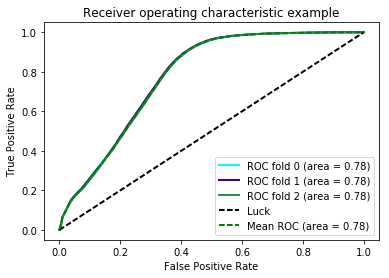

In [12]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

best_pipe = random_search.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen'])
lw = 2

accs = []
i = 0
for (train_index, test_index), color in zip(skf.split(train_data, y), colors):
    pred = best_pipe.fit(train_data.iloc[train_index], y[train_index]).predict_proba(train_data.iloc[test_index])
    #pred = best_pipe.predict_proba(train_data.iloc[test_index])
    fpr, tpr, thresholds = roc_curve(y[test_index], pred[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
    acc = best_pipe.score(train_data.iloc[test_index], y[test_index])
    accs.append(acc)
    print "ROC fold {} accuracy: {:.4f}".format(i, acc)
    i += 1
    
print "Mean accuracy: {:.4f} (std: {:.4f})".format(np.mean(accs), np.std(accs))
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= skf.get_n_splits(train_data, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()